# LBPM Simulation Dashboard
___
**Author Contact:**<br>
Email: [bcchang@utexas.edu](mailto:bcchang@utexas.edu)

This notebook provides some analysis tools for a multiphase LBPM simulation.


## 0. Import some packages

In [8]:
# Utility packages
import pathlib
import re

# Data structures & manipulations
import numpy as np
import pandas as pd

# Image visualization
import pyvista as pv
pv.set_jupyter_backend('trame')
import matplotlib.pyplot as plt

# Jupyter widgets
from ipywidgets import interact, interactive, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output


### Let's first define the path to our simulation directory.

This directory should contain the files associated with a Color model simulation from LBPM. In this example, it should contain:
- Morphological Drainage Files
  - morphdrain.csv
  - *.morphdrain.raw
- timelog.csv
- subphase.csv
- SCAL.csv
- Any 3D visualization files
    - For now, only id_t*.raw files are supported. Silo/HDF5 support coming soon! 

In [9]:
simulation_dir = r"/Users/bchang/Library/CloudStorage/Box-Box/beadpack"
simulation_dir = pathlib.Path(rf"{simulation_dir}")

## 1. Morphological Drainage

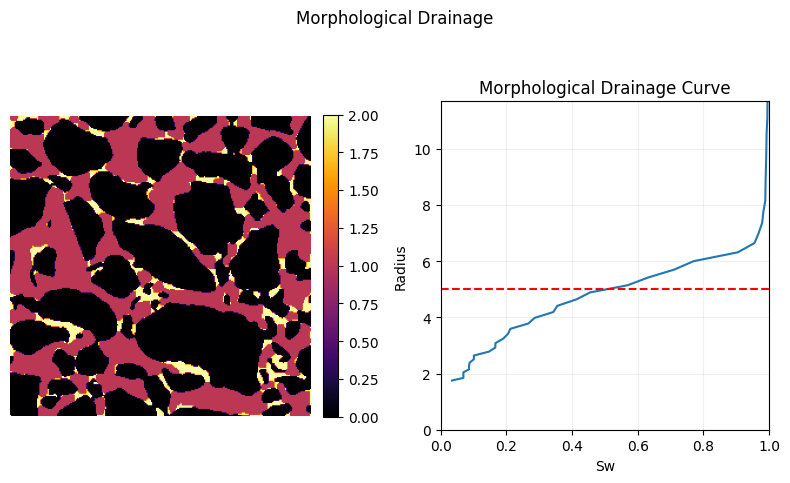

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5),gridspec_kw={"width_ratios":[1, 1]})

# Slice of morphological drainage result
morph_drain_image_path = list(simulation_dir.glob("*.morphdrain.raw"))[0]
morph_drain_img = np.fromfile(morph_drain_image_path, dtype=np.uint8).reshape((256, 256, 256))
im = ax[0].imshow(morph_drain_img[128], cmap="inferno")
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].axis(False)

# Morphological drainage curve
morph_drain_curve = pd.read_csv(simulation_dir / "morphdrain.csv", delimiter=" ")
ax[1].plot(morph_drain_curve["sw"], morph_drain_curve["radius"])
ax[1].plot([0, 1], [5, 5], "r--") 
ax[1].grid(alpha=0.2)
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, morph_drain_curve["radius"].max()])
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
ax[1].set_aspect(asp)
ax[1].set_xlabel("Sw")
ax[1].set_ylabel("Radius")
ax[1].set_title("Morphological Drainage Curve")

fig.suptitle("Morphological Drainage")
fig.subplots_adjust(0.1, 0.1, 0.9, 0.9, 0.25, 0.25)
fig.tight_layout()

## 2. Simulation Monitoring

Here we define general-use functions to plot data and instantiate widgets.

Please see [https://lbpm-sim.org](https://lbpm-sim.org) for details and descriptions about each analysis file.


In [4]:
def plot_simulation_data(analysis: str, x_val: str, y_val: list[str]) -> None:
    # Read in analysis file
    analysis += ".csv"
    sim_df = pd.read_csv(simulation_dir / analysis, delimiter=" ")
    sim_df.insert(0, 'sim.step', np.arange(1, len(sim_df) + 1))
    
    # Plot the data specified by widgets
    fig = plt.figure(dpi=150, figsize=(5,4))
    for y in y_val:
        plt.plot(sim_df[x_val], sim_df[y], label=y)
    plt.xlabel(x_val)
    plt.legend()
    plt.tight_layout()

    
def _get_widgets() -> tuple[widgets]:

    analysis_widget = widgets.Dropdown(options=["timelog", "SCAL", "subphase"],
                                       description="Analysis file",
                                       value="timelog",
                                       style={"description_width": "initial"})
    
    analysis_csv = analysis_widget.value + ".csv"
    df_keys = pd.read_csv(simulation_dir / analysis_csv, delimiter=" ").keys()
    df_keys.insert(0, "sim.step")
    
    x_val_widget = widgets.Dropdown(options=df_keys,
                                description="X Data",
                                value=df_keys[0])

    y_val_widget = widgets.SelectMultiple(options=df_keys,
                                          description="Y Data",
                                          value=[df_keys[1]])

    return analysis_widget, x_val_widget, y_val_widget
    

def _update_xy_widgets(*args):
    analysis_csv = analysis_widget.value + ".csv"
    df_keys = pd.read_csv(simulation_dir / analysis_csv, delimiter=" ").keys()
    df_keys = df_keys.insert(0, "sim.step")
    print(df_keys)

    x_val_widget.options = df_keys
    y_val_widget.options = df_keys


In [5]:
# analysis_widget = _get_analysis_widget()
analysis_widget, x_val_widget, y_val_widget = _get_widgets()
analysis_widget.observe(_update_xy_widgets, 'value')
interact(plot_simulation_data, analysis=analysis_widget, x_val=x_val_widget, y_val=y_val_widget)

interactive(children=(Dropdown(description='Analysis file', options=('timelog', 'SCAL', 'subphase'), style=Des…

<function __main__.plot_simulation_data(analysis: str, x_val: str, y_val: list[str]) -> None>

## 3. Visualization

In [6]:
def _get_timesteps(sim_dir) -> list[int]:
    vis_dir_list = list(sim_dir.glob("id_t*"))
    vis_dir_list = [vis_dir.name for vis_dir in vis_dir_list]
    timesteps = [int(re.findall(r"\d+", vis_dir)[0]) // 1000 for vis_dir in vis_dir_list]
    timesteps = sorted(timesteps)
    return timesteps

In [7]:
timesteps = _get_timesteps(simulation_dir)
print("Timesteps")
print([f"{i}: {timesteps[i]}" for i in range(len(timesteps))])

plotter_obj = pv.Plotter(lighting='three lights')

def create_mesh(sample: float) -> None:

    timesteps = _get_timesteps(simulation_dir)
    
    sample_file = simulation_dir / f"id_t{timesteps[int(sample)]}000.raw"
    # print(f"Selected timestep: {timesteps[sample]}")

    sample_img = np.fromfile(sample_file, dtype=np.uint8).reshape((256, 256, 256))
    
    solid_vol = (sample_img == 0).astype(np.uint8)
    nw_vol = (sample_img == 1).astype(np.uint8)

    nw_vol = np.pad(nw_vol, ((1, 1), (1, 1), (1, 1)), constant_values=0)
    
    solid_vtk_obj = pv.wrap(solid_vol)
    nw_vtk_obj = pv.wrap(nw_vol)
    
    solid_contour = solid_vtk_obj.contour(isosurfaces=[0.5])
    nw_contour = nw_vtk_obj.contour(isosurfaces=[0.5])
    # contours = pv_image_obj.contour(isosurfaces=[0.5])
    plotter_obj.add_mesh(solid_contour, opacity=0.2, color=(0.60,0.93,1.00), name="solid_mesh")
    plotter_obj.add_mesh(nw_contour, opacity=1, color=(191/255, 87/255, 0), name="nw_mesh")

    return

plotter_obj.add_slider_widget(create_mesh, [0, len(timesteps)-1], title="Simulation Step", fmt="%.0f", value=0)
plotter_obj.show(jupyter_backend='server')

Timesteps
['0: 30', '1: 67', '2: 104', '3: 141', '4: 179', '5: 217', '6: 255', '7: 293', '8: 331', '9: 370', '10: 409', '11: 448', '12: 487', '13: 526']


Widget(value='<iframe src="http://localhost:58966/index.html?ui=P_0x2aac725d0_0&reconnect=auto" class="pyvista…